### Import of the modules

In [20]:
import random
import heapq
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

from typing import Any, List, Tuple
from networkx.classes import DiGraph
from typing import Optional
from timeit import default_timer as timer

matplotlib.use('TkAgg')

### Generation of random DAGs

In [21]:
def generate_random_dag(num_nodes: int) -> dict[str, list[Any]]:
    edges = []
    for j in range(1, num_nodes):
        if random.choice([True, False]):
            edges.append((0, j))
    for i in range(1, num_nodes - 1):
        if random.choice([True, False]):
            edges.append((i, num_nodes - 1))
    for i in range(1, num_nodes - 1):
        for j in range(i + 1, num_nodes - 1):
            if random.choice([True, False]):
                edges.append((i, j))
    return {"nodes": list(range(num_nodes)), "edges": edges}

In [22]:
def assign_subsets_and_features(dag: dict[str,list[Any]]) -> DiGraph:
    """Attribue un niveau `subset` et une caractéristique aléatoire (0-10) à chaque nœud."""
    G = nx.DiGraph()
    G.add_nodes_from(dag["nodes"])
    G.add_edges_from(dag["edges"])

    # Calculer les niveaux des nœuds avec un ordre topologique
    levels = {node: 0 for node in G.nodes}
    for node in nx.topological_sort(G):
        for successor in G.successors(node):
            levels[successor] = max(levels[successor], levels[node] + 1)

    # Générer une caractéristique aléatoire pour chaque nœud ( temps d'execusion par exemple)
    features = {node: random.randint(1, 10) for node in G.nodes}

    nx.set_node_attributes(G, levels, "subset")
    nx.set_node_attributes(G, features, "feature")
    return G

### Implementation of the fonctions used in the algo

In [23]:
class Task:
    def __init__(self, id: int, duration: int):
        self.id = id
        self.duration = duration
        self.start_time: Optional[int] = None
        self.end_time: Optional[int] = None
        self.processor: Optional[int] = None

In [24]:
def find_earliest_processor(processor_times: list[int]) -> int:
    return min(range(len(processor_times)), key=lambda p: processor_times[p])

In [25]:
def find_same_processor(predecessors: list[int], schedule: list[Task]) -> Optional[int]:
    for task in schedule:
        if task.id in predecessors:
            return task.processor
    return None


In [26]:
def calculate_latest_finish(graph: nx.DiGraph, task_durations: dict[int,int], debug = False) -> dict[int,int]:
    latest_finish = {node: 0 for node in graph.nodes}
    topo_order = list(nx.topological_sort(graph))
    if debug:
        print(topo_order)

    for node in topo_order:
        predecessors = list(graph.predecessors(node))
        if predecessors:
            latest_finish[node] = max(latest_finish[pred] + task_durations[pred] for pred in predecessors)

    return latest_finish 

In [27]:
def find_critical_path(dag: DiGraph):
    """ Trouve le chemin critique d'un DAG donné """
    # Calculer les plus longues distances depuis la source
    topological_order = list(nx.topological_sort(dag))
    
    # Initialiser les longueurs de chemins et les prédécesseurs
    longest_path_length = {node: 0 for node in dag.nodes}
    predecessor = {node: None for node in dag.nodes}
    
    # Calculer les longueurs de chemin les plus longues
    for node in topological_order:
        for succ in dag.successors(node):
            new_length = longest_path_length[node] + dag.nodes[node]["feature"]
            if new_length > longest_path_length[succ]:
                longest_path_length[succ] = new_length
                predecessor[succ] = node

    # Trouver le nœud terminal du chemin critique
    end_node = max(longest_path_length, key=longest_path_length.get)

    # Reconstruire le chemin critique en remontant depuis le nœud terminal
    critical_path = []
    node = end_node
    while node is not None:
        critical_path.append(node)
        node = predecessor[node]

    return list(reversed(critical_path)), longest_path_length[end_node]


### Fonctions to plot

In [28]:
def visualize_schedule(schedule: list[Task], num_processors: int, makespan: int):
    _, ax = plt.subplots(figsize=(20, 6))
    for task in schedule:
        if task.start_time is None or task.processor is None:
            continue

        ax.barh(task.processor, task.duration, left=task.start_time, height=0.8, label=f"Task {task.id}")
        # Ajouter le numéro de la tâche au centre de la barre
        # ax.text(task.start_time + task.duration / 2, task.processor, str(task.id),
                #va='center', ha='center', fontsize=10, color='black', fontweight='bold')

    ax.set_xlabel("Time")
    ax.set_ylabel("Processors")
    ax.set_yticks(range(num_processors))
    ax.set_yticklabels([f"Processor {i}" for i in range(num_processors)])
    ax.set_title(f"Task Scheduling Visualization\nMakespan: {makespan}")
    plt.tight_layout()
    plt.show()

In [29]:
def plot_dag(G: DiGraph) -> None:
    pos = nx.multipartite_layout(G, subset_key="subset")  # Utiliser les niveaux pour le layout
    labels = {node: f"{node}\n{G.nodes[node]['feature']}" for node in G.nodes}  # Labels avec caractéristique

    plt.figure(figsize=(8, 6))  # Ajuster la taille du plot
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color="skyblue", arrowsize=20)
    plt.show()  # Afficher directement dans le notebook

### The algorithmes

* MCP 1 : it's the classic dynamic critical path

In [30]:
def MCP_1(graph: nx.DiGraph, task_durations: dict[int,int], num_processors: int, debug = False) -> tuple[list[Task],int]:
    latest_finish = calculate_latest_finish(graph, task_durations, debug)

    if debug:
        print(latest_finish)
    priority_queue = []

    # Priority is the latest finish time
    for node in graph.nodes:
        heapq.heappush(priority_queue, (latest_finish[node], node))

    schedule = []
    min_processor_time = 0
    assigned_tasks = set()
    processor_times = [0] * num_processors

    while priority_queue:
        _, node = heapq.heappop(priority_queue)
        if debug:
            print(f"node: {node}")
        if node in assigned_tasks:
            continue

        # Check dependency constraints
        dependencies = list(graph.predecessors(node))
        max_dependency_end = max((task.end_time for task in schedule if task.id in dependencies), default=0)
        start_time = max(min_processor_time, max_dependency_end)
        preferred_processor = find_same_processor(dependencies, schedule)

        # First try to allocate the next task to the same core
        # then try to allocate an already used core
        # finally allocate a never used core if there is one
        if preferred_processor is not None and processor_times[preferred_processor] <= start_time:
            processor = preferred_processor
        else:
            available_processors = [p for p in range(num_processors) if processor_times[p] <= start_time]
            if available_processors:
                processor = available_processors[0]
            else:
                processor = find_earliest_processor(processor_times)

        start_time = max(start_time, processor_times[processor])

        if debug:
            print(f"dependencies: {dependencies}")
            print(f"earliest available processor: {min_processor_time}")
            print(f"max dependency end: {max_dependency_end}")
            print(f"processor time: {processor_times[processor]}")

        task = Task(node, task_durations[node])
        task.start_time = start_time
        task.end_time = start_time + task.duration
        task.processor = processor
        schedule.append(task)
        assigned_tasks.add(node)
        processor_times[processor] = task.end_time
        min_processor_time = min(processor_times)

    schedule.sort(key=lambda t: t.start_time)
    makespan = max(processor_times)
    return schedule, makespan

* MCP with communication cost

In [31]:
def MCP_with_communication_cost(graph: nx.DiGraph, task_durations: dict[int, int], num_processors: int, debug=False) -> tuple[list[Task], int]:
    latest_finish = calculate_latest_finish(graph, task_durations, debug)

    if debug:
        print(latest_finish)
    priority_queue = []

    # Priority is the latest finish time
    for node in graph.nodes:
        heapq.heappush(priority_queue, (latest_finish[node], node))

    schedule = []
    min_processor_time = 0
    assigned_tasks = set()
    processor_times = [0] * num_processors

    while priority_queue:
        _, node = heapq.heappop(priority_queue)
        if debug:
            print(f"node: {node}")
        if node in assigned_tasks:
            continue

        # Check dependency constraints
        dependencies = list(graph.predecessors(node))
        max_dependency_end = max((task.end_time for task in schedule if task.id in dependencies), default=0)
        start_time = max(min_processor_time, max_dependency_end)
        preferred_processor = find_same_processor(dependencies, schedule)

        # First try to allocate the next task to the same core
        # then try to allocate an already used core
        # finally allocate a never used core if there is one
        if preferred_processor is not None and processor_times[preferred_processor] <= start_time:
            processor = preferred_processor
        else:
            available_processors = [p for p in range(num_processors) if processor_times[p] <= start_time]
            if available_processors:
                processor = available_processors[0]
            else:
                processor = find_earliest_processor(processor_times)

        # Add communication cost if the task is assigned to a different processor
        if preferred_processor is not None and processor != preferred_processor:
            start_time += communication_cost

        start_time = max(start_time, processor_times[processor])

        if debug:
            print(f"dependencies: {dependencies}")
            print(f"earliest available processor: {min_processor_time}")
            print(f"max dependency end: {max_dependency_end}")
            print(f"processor time: {processor_times[processor]}")

        task = Task(node, task_durations[node])
        task.start_time = start_time
        task.end_time = start_time + task.duration
        task.processor = processor
        schedule.append(task)
        assigned_tasks.add(node)
        processor_times[processor] = task.end_time
        min_processor_time = min(processor_times)

    schedule.sort(key=lambda t: t.start_time)
    makespan = max(processor_times)
    return schedule, makespan

* MCP with communicatio cost and fail of processors

In [32]:
class Task:
    def __init__(self, id, duration):
        self.id = id
        self.duration = duration
        self.start_time = 0
        self.end_time = 0
        self.processor = None

In [33]:
def MCP_with_comm_and_failure(graph: nx.DiGraph, task_durations: dict[int, int], num_processors: int, debug=False) -> tuple[list[Task], int]:
    latest_finish = calculate_latest_finish(graph, task_durations, debug)

    if debug:
        print(latest_finish)
    priority_queue = []

    # Priority is the latest finish time
    for node in graph.nodes:
        heapq.heappush(priority_queue, (latest_finish[node], node))

    schedule = []
    min_processor_time = 0
    assigned_tasks = set()
    processor_times = [0] * num_processors

            # Randomly select a processor to fail
    #failed_processor = random.randint(0, num_processors - 1)
    #failure_time = random.uniform(0, max(task_durations.values()) * len(graph.nodes))

    failed_processor = 0
    failure_time = 150

    if debug:
        print(f"Processor {failed_processor} will fail at time {failure_time}")

    while priority_queue:
        _, node = heapq.heappop(priority_queue)
        if debug:
            print(f"node: {node}")
        if node in assigned_tasks:
            continue

        # Check dependency constraints
        dependencies = list(graph.predecessors(node))
        max_dependency_end = max((task.end_time for task in schedule if task.id in dependencies), default=0)
        start_time = max(min_processor_time, max_dependency_end)
        preferred_processor = find_same_processor(dependencies, schedule)

        # First try to allocate the next task to the same core
        # then try to allocate an already used core
        # finally allocate a never used core if there is one
        if preferred_processor is not None and processor_times[preferred_processor] <= start_time:
            processor = preferred_processor
        else:
            available_processors = [p for p in range(num_processors) if processor_times[p] <= start_time]
            if available_processors:
                processor = available_processors[0]
            else:
                processor = find_earliest_processor(processor_times)

        # Simulate processor failure
        if start_time >= failure_time and processor == failed_processor:
            if debug:
                print(f"Processor {failed_processor} failed. Reassigning task {node}.")

            # Find the processor with the minimum load after the failure
            available_processors = [p for p in range(num_processors) if p != failed_processor]
            processor = min(available_processors, key=lambda p: processor_times[p])
            
        # Add communication cost if the task is assigned to a different processor
        if preferred_processor is not None and processor != preferred_processor:
            start_time += communication_cost


        start_time = max(start_time, processor_times[processor])

        if debug:
            print(f"dependencies: {dependencies}")
            print(f"earliest available processor: {min_processor_time}")
            print(f"max dependency end: {max_dependency_end}")
            print(f"processor time: {processor_times[processor]}")

        task = Task(node, task_durations[node])
        task.start_time = start_time
        task.end_time = start_time + task.duration
        task.processor = processor
        schedule.append(task)
        assigned_tasks.add(node)
        processor_times[processor] = task.end_time
        min_processor_time = min(processor_times)

    schedule.sort(key=lambda t: t.start_time)
    makespan = max(processor_times)
    return schedule, makespan

In [34]:
import random
import math
import networkx as nx

class Task:
    def __init__(self, id, duration):
        self.id = id
        self.duration = duration
        self.start_time = 0
        self.end_time = 0
        self.processor = None

def calculate_makespan(schedule, num_processors):
    processor_times = [0] * num_processors
    for task in schedule:
        processor_times[task.processor] = task.end_time
    return max(processor_times)

def initial_solution(graph, task_durations, num_processors):
    schedule = []
    processor_times = [0] * num_processors

    for node in graph.nodes:
        task = Task(node, task_durations[node])
        processor = random.randint(0, num_processors - 1)
        task.processor = processor
        task.start_time = processor_times[processor]
        task.end_time = task.start_time + task.duration
        processor_times[processor] = task.end_time
        schedule.append(task)

    return schedule

def neighbor_solution(schedule, num_processors):
    new_schedule = schedule[:]
    task = random.choice(new_schedule)
    new_processor = random.randint(0, num_processors - 1)
    task.processor = new_processor

    # Recalculate start and end times
    processor_times = [0] * num_processors
    for t in new_schedule:
        processor_times[t.processor] = max(processor_times[t.processor], t.end_time)

    for t in new_schedule:
        dependencies = list(G.predecessors(t.id))
        max_dependency_end = max((task.end_time for task in new_schedule if task.id in dependencies), default=0)
        t.start_time = max(max_dependency_end, processor_times[t.processor])
        t.end_time = t.start_time + t.duration
        processor_times[t.processor] = t.end_time

    return new_schedule

def simulated_annealing(graph, task_durations, num_processors, initial_temp, temp_reduction, stopping_temp):
    current_solution = initial_solution(graph, task_durations, num_processors)
    current_makespan = calculate_makespan(current_solution, num_processors)
    best_solution = current_solution
    best_makespan = current_makespan

    temperature = initial_temp

    while temperature > stopping_temp:
        new_solution = neighbor_solution(current_solution, num_processors)
        new_makespan = calculate_makespan(new_solution, num_processors)

        if new_makespan < best_makespan:
            best_solution = new_solution
            best_makespan = new_makespan
            current_solution = new_solution
            current_makespan = new_makespan
        else:
            acceptance_probability = math.exp((current_makespan - new_makespan) / temperature)
            if random.random() < acceptance_probability:
                current_solution = new_solution
                current_makespan = new_makespan

        temperature *= temp_reduction

    return best_solution, best_makespan


initial_temp = 1000
temp_reduction = 0.99
stopping_temp = 1

### Initialisation of the conditions's tests & plot of the graph

In [35]:
start = timer()
num_nodes = 10000
num_processors = 6
dag = generate_random_dag(num_nodes)
G = assign_subsets_and_features(dag)
task_durations = {node: G.nodes[node]['feature'] for node in G.nodes}  # Labels avec caractéristique

%matplotlib inline  

# plot_dag(G)

* test MCP 1 ( DCP in deed )

Required time: 870.7937557999976s
Critical path: [0, 4, 5, 7, 9, 11, 12, 14, 19, 20, 23, 24, 26, 27, 28, 30, 31, 33, 35, 37, 43, 46, 47, 48, 50, 52, 53, 54, 57, 59, 61, 62, 63, 64, 68, 70, 71, 73, 74, 75, 76, 80, 81, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 97, 98, 99, 101, 103, 106, 110, 111, 112, 113, 117, 122, 124, 125, 128, 129, 131, 132, 135, 136, 137, 140, 141, 143, 144, 145, 146, 147, 150, 152, 154, 155, 158, 159, 161, 162, 163, 167, 168, 170, 172, 175, 176, 178, 179, 180, 183, 184, 186, 188, 189, 191, 192, 193, 194, 196, 197, 200, 202, 204, 205, 207, 210, 211, 212, 213, 214, 215, 222, 223, 224, 225, 226, 228, 229, 230, 231, 234, 235, 239, 241, 244, 247, 248, 249, 251, 252, 253, 254, 256, 257, 258, 261, 263, 265, 266, 267, 269, 270, 271, 274, 278, 279, 282, 283, 285, 286, 287, 289, 291, 294, 296, 297, 298, 299, 301, 302, 303, 306, 307, 309, 312, 313, 314, 316, 317, 318, 320, 321, 322, 326, 328, 331, 333, 334, 335, 337, 339, 340, 341, 342, 343, 345, 346, 347, 349, 352, 354, 35

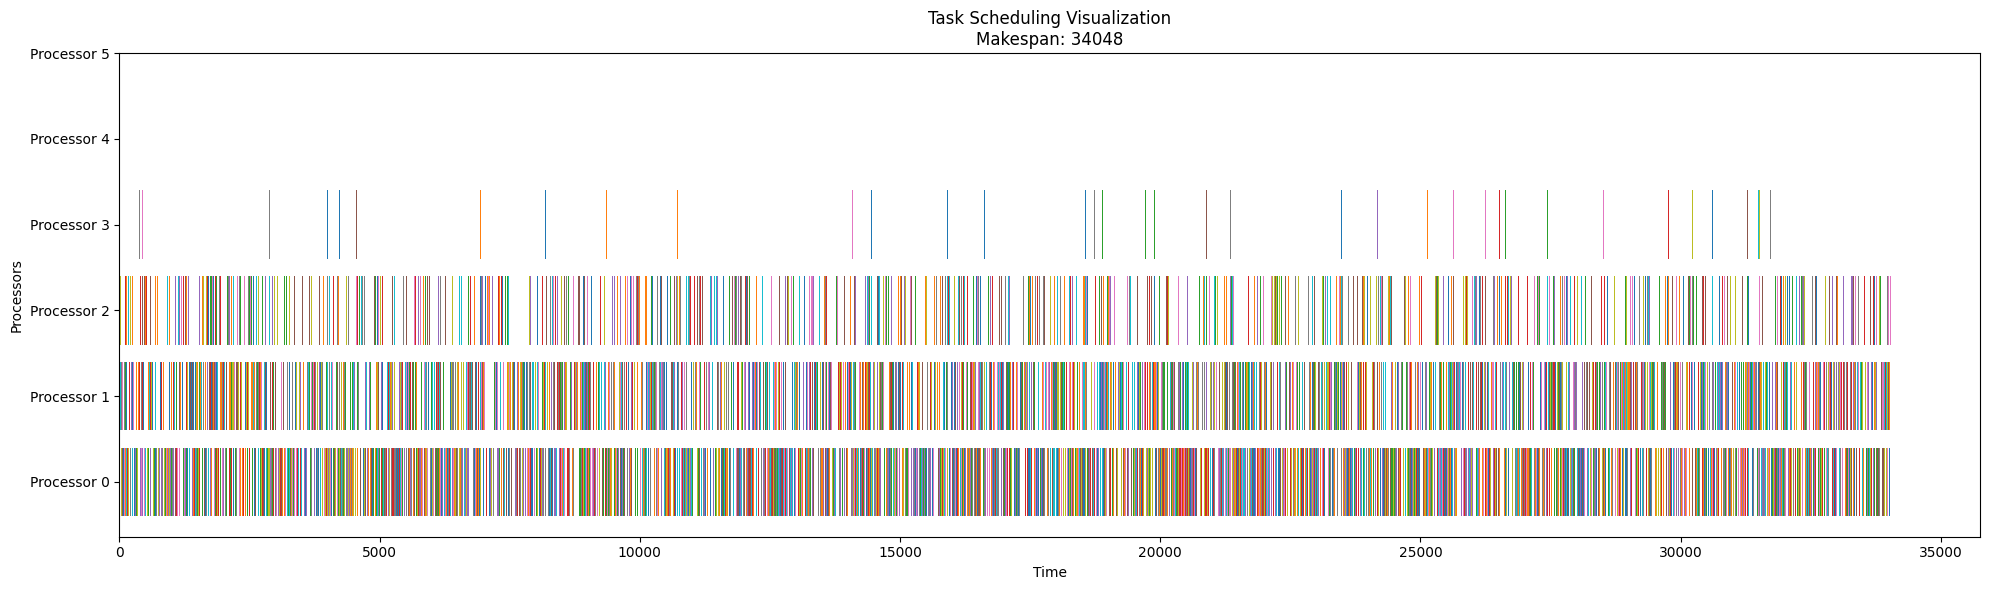

In [36]:
start = timer()
schedule, makespan = MCP_1(G, task_durations, num_processors)
end = timer()

%matplotlib inline  

print(f"Required time: {end-start}s")
critical_path, longest_path_length = find_critical_path(G)
print(f"Critical path: {critical_path}")
print(f"Longest path length: {longest_path_length}")
visualize_schedule(schedule, num_processors, makespan)


* test MCP with comm

Required time: 2775.5234628000035s
Critical path: [0, 4, 5, 7, 9, 11, 12, 14, 19, 20, 23, 24, 26, 27, 28, 30, 31, 33, 35, 37, 43, 46, 47, 48, 50, 52, 53, 54, 57, 59, 61, 62, 63, 64, 68, 70, 71, 73, 74, 75, 76, 80, 81, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 97, 98, 99, 101, 103, 106, 110, 111, 112, 113, 117, 122, 124, 125, 128, 129, 131, 132, 135, 136, 137, 140, 141, 143, 144, 145, 146, 147, 150, 152, 154, 155, 158, 159, 161, 162, 163, 167, 168, 170, 172, 175, 176, 178, 179, 180, 183, 184, 186, 188, 189, 191, 192, 193, 194, 196, 197, 200, 202, 204, 205, 207, 210, 211, 212, 213, 214, 215, 222, 223, 224, 225, 226, 228, 229, 230, 231, 234, 235, 239, 241, 244, 247, 248, 249, 251, 252, 253, 254, 256, 257, 258, 261, 263, 265, 266, 267, 269, 270, 271, 274, 278, 279, 282, 283, 285, 286, 287, 289, 291, 294, 296, 297, 298, 299, 301, 302, 303, 306, 307, 309, 312, 313, 314, 316, 317, 318, 320, 321, 322, 326, 328, 331, 333, 334, 335, 337, 339, 340, 341, 342, 343, 345, 346, 347, 349, 352, 354, 3

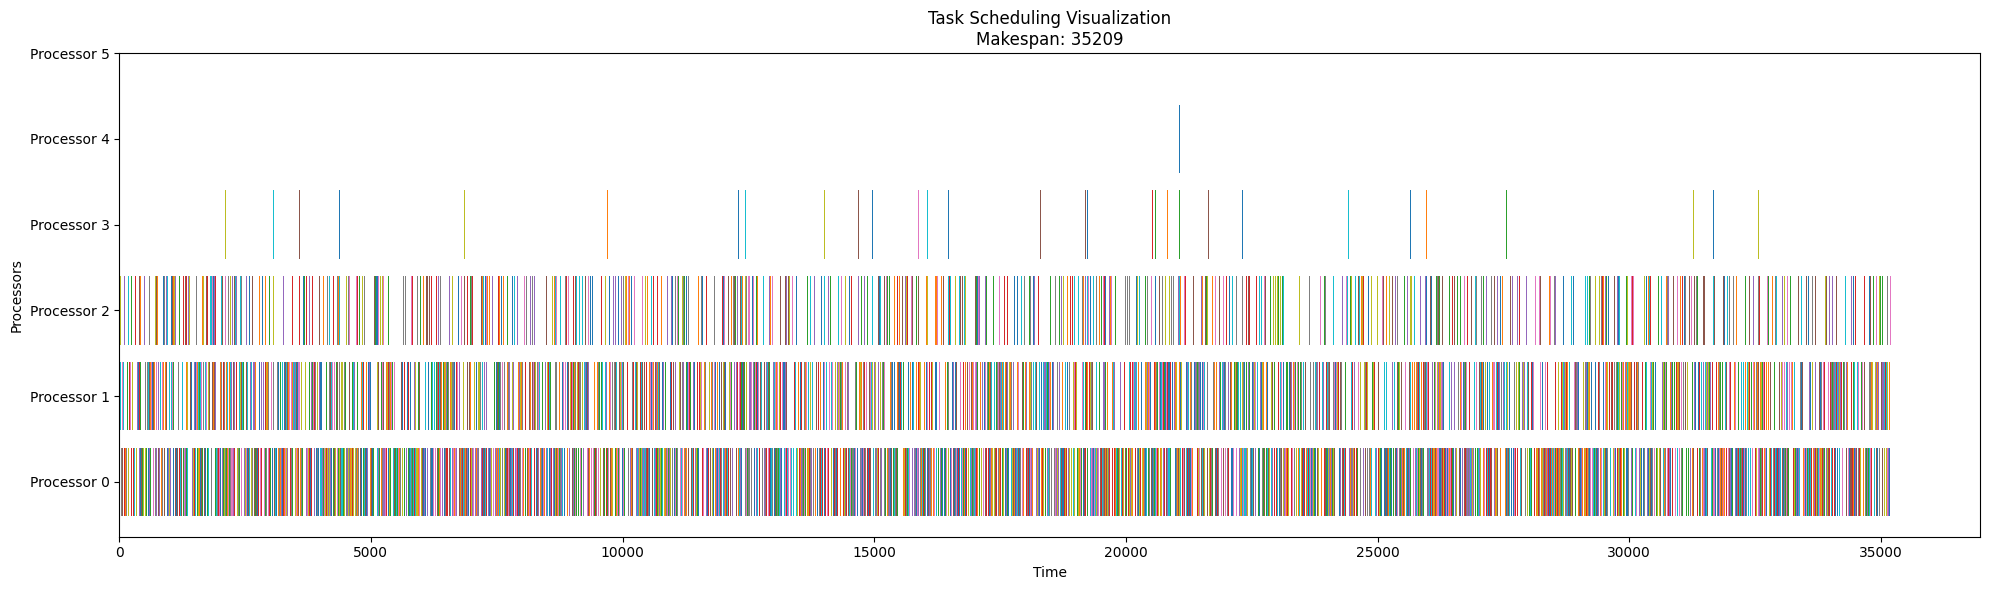

In [37]:
start = timer()
communication_cost = 1
schedule, makespan = MCP_with_communication_cost(G, task_durations, num_processors)
end = timer()

%matplotlib inline  

print(f"Required time: {end-start}s")
critical_path, longest_path_length = find_critical_path(G)
print(f"Critical path: {critical_path}")
print(f"Longest path length: {longest_path_length}")
visualize_schedule(schedule, num_processors, makespan)


* test MCP with comm and failure

In [ ]:
start = timer()
communication_cost = 1
schedule, makespan = MCP_with_comm_and_failure(G, task_durations, num_processors)
end = timer()

%matplotlib inline  

print(f"Required time: {end-start}s")
critical_path, longest_path_length = find_critical_path(G)
print(f"Critical path: {critical_path}")
print(f"Longest path length: {longest_path_length}")
visualize_schedule(schedule, num_processors, makespan)
